In [20]:
!pip install tensorflow

!pip install opencv-python opencv-python-headless opencv-contrib-python


In [21]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [5]:
path = kagglehub.dataset_download("odins0n/ucf-crime-dataset")
print("Path to dataset files:", path)

100%|██████████| 11.0G/11.0G [01:07<00:00, 175MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/odins0n/ucf-crime-dataset/versions/1


In [6]:
train_dir = os.path.join(path, "Train")
test_dir = os.path.join(path, "Test")

classes = ["Fighting", "Robbery", "Shooting", "Stealing", "NormalVideos"]
num_classes = len(classes)

In [22]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

img_width, img_height = 150, 150

def balance_dataset(directory, classes, max_samples_per_class=7140):
    X, y = [], []
    class_to_label = {class_name: i for i, class_name in enumerate(classes)}

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        if not os.path.exists(class_dir):
            continue

        image_files = os.listdir(class_dir)[:max_samples_per_class]

        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (img_width, img_height))
                image = image / 255.0
                X.append(image)
                y.append(class_to_label[class_name])

    return np.array(X), np.array(y)

X_train, y_train = balance_dataset(train_dir, classes)
X_test, y_test = balance_dataset(test_dir, classes)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)


In [23]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [24]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('crime_classification_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1785/1785 ━━━━━━━━━━━━━━━━━━━━ 207s 115ms/step - accuracy: 0.4851 - loss: 1.2474 - val_accuracy: 0.8223 - val_loss: 0.4818
Epoch 2/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 200s 112ms/step - accuracy: 0.8075 - loss: 0.5391 - val_accuracy: 0.9459 - val_loss: 0.1826
Epoch 3/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 198s 111ms/step - accuracy: 0.8869 - loss: 0.3380 - val_accuracy: 0.9636 - val_loss: 0.1241
Epoch 4/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 199s 112ms/step - accuracy: 0.9150 - loss: 0.2530 - val_accuracy: 0.9686 - val_loss: 0.1023
Epoch 5/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 199s 111ms/step - accuracy: 0.9272 - loss: 0.2215 - val_accuracy: 0.9725 - val_loss: 0.0919
Epoch 6/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 198s 111ms/step - accuracy: 0.9389 - loss: 0.1856 - val_accuracy: 0.9734 - val_loss: 0.0814
Epoch 7/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 198s 111ms/step - accuracy: 0.9443 - loss: 0.1647 - val_accuracy: 0.9831 - val_loss: 0.0563
Epoch 8/30
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 198s 111ms/step - accuracy: 0.9

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Train Accuracy: {history.history['accuracy'][-1] * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.9889 - loss: 0.0375
Train Accuracy: 97.46%
Test Accuracy: 98.95%


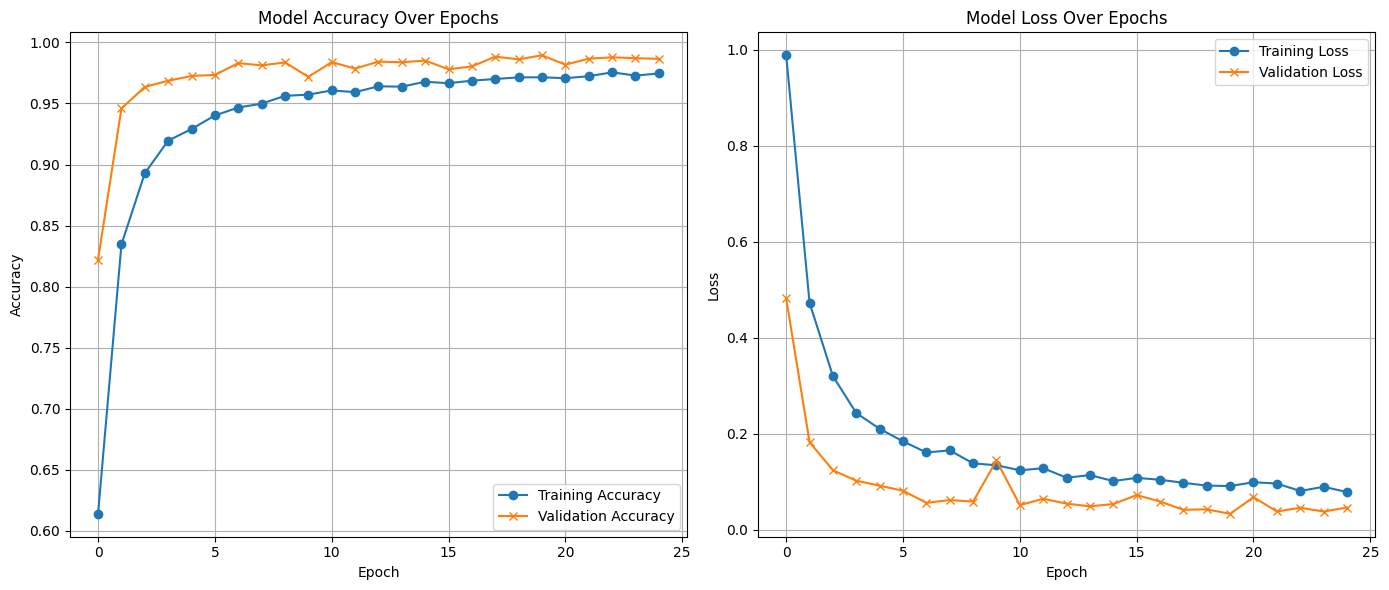

224/224 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step


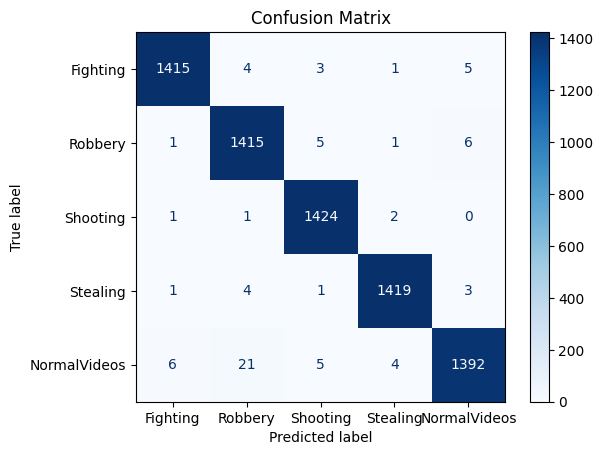

In [27]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

predicted crime is :10: Robbery
predicted crime is: 10: Robbery


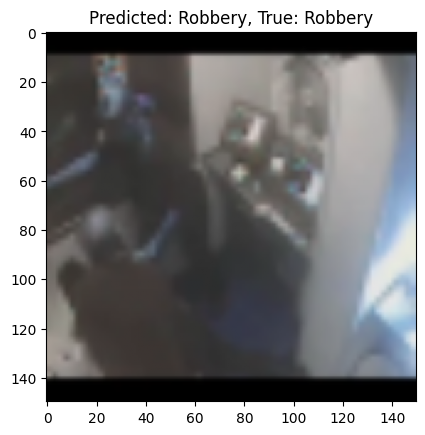

In [29]:
image_index = 10
predicted_label = classes[y_pred[image_index]]
true_label = classes[y_test[image_index]]

print(f"predicted crime is :{image_index}: {predicted_label}")
print(f"predicted crime is: {image_index}: {true_label}")

plt.imshow(X_test[image_index])  # عرض الصورة
plt.title(f"Predicted: {predicted_label}, True: {true_label}")
plt.show()


In [31]:
model.save('cnn3_model.keras')